In [1]:
import torch
torch.__version__

'2.5.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision.models import mobilenet_v3_large
import random
from torch.utils.data import WeightedRandomSampler

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [5]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by 10 degrees
    transforms.RandomResizedCrop(
        size=IMG_SIZE,  # Output size
        scale=(0.8, 1.0)  # Range of the random crop size relative to the input size
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
test transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [7]:
data = pd.read_csv('D://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013v2_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33303 entries, 0 to 33302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33303 non-null  object
 1   emotion  33303 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.5+ KB


In [8]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26974
Validation set size: 2998
Test set size: 3331


In [9]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [10]:
train_labels = data_train["emotion"]
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels]

# Create a weighted sampler
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [11]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


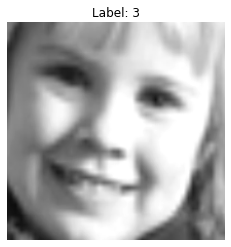

In [12]:
# Define the mean and std used for normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Denormalize function
def denormalize(tensor, mean, std):
    # Clone the tensor to avoid modifying the original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization: (t * s) + m
    return tensor

# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Denormalize the image
image = denormalize(image, mean, std)

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Clip the values to the valid range [0, 1]
image = image.clip(0, 1)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [13]:
image, label = train_dataset[0]
image.shape

torch.Size([3, 224, 224])

## Build Vision Transformer (ViT) Model

In [14]:
from torch import nn

In [15]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [16]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [17]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [18]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0., # Dropout for attention projection
                 mlp_dropout:float=0., # Dropout for dense/MLP layers 
                 embedding_dropout:float=0., # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()
         
        assert img_size % 32 == 0, f"Image size must be divisible by 32, image size: {img_size}"
        
        self.mobilenet = mobilenet_v3_large(pretrained=True).features
        
        self.projection = nn.Conv2d(in_channels=960, 
                                    out_channels=embedding_dim,
                                    kernel_size=1)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.num_patches = (img_size // 32) ** 2  # MobileNet reduces spatial size by 32x
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        
        batch_size = pixel_values.shape[0]

        # Extract features using MobileNet
        features = self.mobilenet(pixel_values)  # Output shape: (batch_size, 1280, H', W')
        features = self.projection(features)  # Project to embedding_dim: (batch_size, embedding_dim, H', W')

        # Flatten the feature maps into a sequence of tokens
        features = features.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, embedding_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = torch.cat((class_token, features), dim=1)  # Shape: (batch_size, num_patches + 1, embedding_dim)

        x = x + self.position_embedding

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        return logits

## Model Training

In [19]:
model = ViT(num_classes=len(class_names), in_channels=3, patch_size=8, num_heads=8, embedding_dim=512, num_transformer_layers=12)

C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
from torchinfo import summary

summary(
    model=model,
    input_size=(1, 3, 224, 224),  # (batch_size, in_channels, img_size, img_size)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [1, 3, 224, 224] [1, 7]          26,112          True
├─Sequential (mobilenet)                                     [1, 3, 224, 224] [1, 960, 7, 7]  --              True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 16, 112, 112] --              True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 16, 112, 112] 432             True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112] [1, 16, 112, 112] 32              True
│    │    └─Hardswish (2)                                    [1, 16, 112, 112] [1, 16, 112, 112] --              --
│    └─InvertedResidual (1)                                  [1, 16, 112, 112] [1, 16, 112, 112] --              True
│    │    └─Sequential (block)                               [1, 

In [21]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group.setdefault('rho', rho)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                p.add_(scale * p.grad)  # Perturbasi parameter
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # Kembalikan parameter awal
        self.base_optimizer.step()  # Update parameter
        if zero_grad:
            self.zero_grad()

    def _grad_norm(self):
        norm = torch.norm(
            torch.stack([
                torch.norm(p.grad) for group in self.param_groups for p in group["params"] if p.grad is not None
            ]),
            p=2
        )
        return norm

    def step(self, closure=None):
        raise NotImplementedError("Gunakan first_step() dan second_step().")

In [22]:
EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, generator=torch.Generator().manual_seed(SEED), sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

base_optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
optimizer = SAM(model.parameters(), base_optimizer, rho=0.05)
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Define path
SAVE_PATH = "D://Kuliah//UPI//SEMESTER 8//hasil eksperimen"
os.makedirs(SAVE_PATH, exist_ok=True)

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the best metric for model saving
best_val_accuracy = -float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        # Second forward-backward pass
        criterion(model(inputs), targets).backward()
        optimizer.second_step(zero_grad=True)  # Update weights

        # Update statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{train_loss / (batch_idx + 1):.4f}",
            "Acc": f"{correct / total:.4f}"
        })

    # Calculate training accuracy and loss
    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Print training summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_targets = []
    all_predicted = []

    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} (Validation)")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

            # Collect all targets and predictions for F1-score
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                "Acc": f"{val_correct / val_total:.4f}"
            })

    # Calculate validation accuracy, loss, and F1-score
    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_targets, all_predicted, average="weighted")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # Step the learning rate scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_path = os.path.join(SAVE_PATH, "backbone_mobilenetv3_balancing_best.pt")
        torch.save({
            "model_state_dict": model.state_dict(),
            "class_weights": class_weights
        }, model_path)
#         torch.save(model.state_dict(), model_path)
        print(f"Best model saved at {model_path} with val accuracy: {best_val_accuracy:.4f}")

    # Save loss and accuracy plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(SAVE_PATH, "backbone_mobilenetv3_balancing_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    accuracy_plot_path = os.path.join(SAVE_PATH, "backbone_mobilenetv3_balancing_accuracy.png")
    plt.savefig(accuracy_plot_path)
    plt.close()

Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [06:20<00:00,  1.11it/s, Loss=1.5998, Acc=0.3772]


Epoch 1/1000: Train Loss: 1.5998, Train Acc: 0.3772


Epoch 1/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.51it/s, Loss=1.3432, Acc=0.4810]


Epoch 1/1000: Val Loss: 1.3432, Val Acc: 0.4810, Val F1: 0.4713
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.4810


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [06:28<00:00,  1.09it/s, Loss=1.2142, Acc=0.5390]


Epoch 2/1000: Train Loss: 1.2142, Train Acc: 0.5390


Epoch 2/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.22it/s, Loss=1.2062, Acc=0.5510]


Epoch 2/1000: Val Loss: 1.2062, Val Acc: 0.5510, Val F1: 0.5502
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.5510


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [06:26<00:00,  1.09it/s, Loss=1.0730, Acc=0.5942]


Epoch 3/1000: Train Loss: 1.0730, Train Acc: 0.5942


Epoch 3/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.70it/s, Loss=1.1285, Acc=0.5771]


Epoch 3/1000: Val Loss: 1.1285, Val Acc: 0.5771, Val F1: 0.5755
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.5771


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [06:11<00:00,  1.14it/s, Loss=0.9698, Acc=0.6334]


Epoch 4/1000: Train Loss: 0.9698, Train Acc: 0.6334


Epoch 4/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.71it/s, Loss=1.0357, Acc=0.6144]


Epoch 4/1000: Val Loss: 1.0357, Val Acc: 0.6144, Val F1: 0.6047
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6144


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [06:25<00:00,  1.09it/s, Loss=0.9078, Acc=0.6572]


Epoch 5/1000: Train Loss: 0.9078, Train Acc: 0.6572


Epoch 5/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.11it/s, Loss=1.0276, Acc=0.6161]


Epoch 5/1000: Val Loss: 1.0276, Val Acc: 0.6161, Val F1: 0.6154
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6161


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [06:43<00:00,  1.05it/s, Loss=0.8688, Acc=0.6702]


Epoch 6/1000: Train Loss: 0.8688, Train Acc: 0.6702


Epoch 6/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.11it/s, Loss=1.0049, Acc=0.6181]


Epoch 6/1000: Val Loss: 1.0049, Val Acc: 0.6181, Val F1: 0.6061
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6181


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [06:42<00:00,  1.05it/s, Loss=0.8165, Acc=0.6900]


Epoch 7/1000: Train Loss: 0.8165, Train Acc: 0.6900


Epoch 7/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.15it/s, Loss=0.9814, Acc=0.6318]


Epoch 7/1000: Val Loss: 0.9814, Val Acc: 0.6318, Val F1: 0.6245
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6318


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [06:39<00:00,  1.06it/s, Loss=0.7817, Acc=0.7071]


Epoch 8/1000: Train Loss: 0.7817, Train Acc: 0.7071


Epoch 8/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:07<00:00,  6.22it/s, Loss=0.9741, Acc=0.6331]


Epoch 8/1000: Val Loss: 0.9741, Val Acc: 0.6331, Val F1: 0.6299
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6331


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [06:42<00:00,  1.05it/s, Loss=0.7585, Acc=0.7161]


Epoch 9/1000: Train Loss: 0.7585, Train Acc: 0.7161


Epoch 9/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:08<00:00,  5.76it/s, Loss=0.9866, Acc=0.6318]


Epoch 9/1000: Val Loss: 0.9866, Val Acc: 0.6318, Val F1: 0.6258
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [06:41<00:00,  1.05it/s, Loss=0.7384, Acc=0.7249]


Epoch 10/1000: Train Loss: 0.7384, Train Acc: 0.7249


Epoch 10/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:08<00:00,  5.79it/s, Loss=0.9471, Acc=0.6448]


Epoch 10/1000: Val Loss: 0.9471, Val Acc: 0.6448, Val F1: 0.6412
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6448


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [06:44<00:00,  1.04it/s, Loss=0.7036, Acc=0.7337]


Epoch 11/1000: Train Loss: 0.7036, Train Acc: 0.7337


Epoch 11/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.35it/s, Loss=0.9455, Acc=0.6548]


Epoch 11/1000: Val Loss: 0.9455, Val Acc: 0.6548, Val F1: 0.6550
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6548


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [06:17<00:00,  1.12it/s, Loss=0.6793, Acc=0.7468]


Epoch 12/1000: Train Loss: 0.6793, Train Acc: 0.7468


Epoch 12/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.70it/s, Loss=0.9496, Acc=0.6481]


Epoch 12/1000: Val Loss: 0.9496, Val Acc: 0.6481, Val F1: 0.6479
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [06:11<00:00,  1.14it/s, Loss=0.6541, Acc=0.7547]


Epoch 13/1000: Train Loss: 0.6541, Train Acc: 0.7547


Epoch 13/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.73it/s, Loss=0.9368, Acc=0.6634]


Epoch 13/1000: Val Loss: 0.9368, Val Acc: 0.6634, Val F1: 0.6542
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6634


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [06:11<00:00,  1.14it/s, Loss=0.6280, Acc=0.7679]


Epoch 14/1000: Train Loss: 0.6280, Train Acc: 0.7679


Epoch 14/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.69it/s, Loss=0.9172, Acc=0.6658]


Epoch 14/1000: Val Loss: 0.9172, Val Acc: 0.6658, Val F1: 0.6617
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6658


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [06:10<00:00,  1.14it/s, Loss=0.6021, Acc=0.7791]


Epoch 15/1000: Train Loss: 0.6021, Train Acc: 0.7791


Epoch 15/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:06<00:00,  6.73it/s, Loss=0.9254, Acc=0.6588]


Epoch 15/1000: Val Loss: 0.9254, Val Acc: 0.6588, Val F1: 0.6573
Current Learning Rate: 3e-05


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [06:10<00:00,  1.14it/s, Loss=0.5696, Acc=0.7898]


Epoch 16/1000: Train Loss: 0.5696, Train Acc: 0.7898


Epoch 16/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.37it/s, Loss=0.9071, Acc=0.6778]


Epoch 16/1000: Val Loss: 0.9071, Val Acc: 0.6778, Val F1: 0.6738
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6778


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [06:24<00:00,  1.10it/s, Loss=0.5509, Acc=0.8027]


Epoch 17/1000: Train Loss: 0.5509, Train Acc: 0.8027


Epoch 17/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.46it/s, Loss=0.9548, Acc=0.6614]


Epoch 17/1000: Val Loss: 0.9548, Val Acc: 0.6614, Val F1: 0.6597
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [06:20<00:00,  1.11it/s, Loss=0.5169, Acc=0.8138]


Epoch 18/1000: Train Loss: 0.5169, Train Acc: 0.8138


Epoch 18/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.47it/s, Loss=0.9231, Acc=0.6698]


Epoch 18/1000: Val Loss: 0.9231, Val Acc: 0.6698, Val F1: 0.6695
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [06:24<00:00,  1.10it/s, Loss=0.4915, Acc=0.8246]


Epoch 19/1000: Train Loss: 0.4915, Train Acc: 0.8246


Epoch 19/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.48it/s, Loss=0.9221, Acc=0.6785]


Epoch 19/1000: Val Loss: 0.9221, Val Acc: 0.6785, Val F1: 0.6770
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6785


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [06:27<00:00,  1.09it/s, Loss=0.4691, Acc=0.8332]


Epoch 20/1000: Train Loss: 0.4691, Train Acc: 0.8332


Epoch 20/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.41it/s, Loss=0.9219, Acc=0.6711]


Epoch 20/1000: Val Loss: 0.9219, Val Acc: 0.6711, Val F1: 0.6710
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [06:26<00:00,  1.09it/s, Loss=0.4439, Acc=0.8430]


Epoch 21/1000: Train Loss: 0.4439, Train Acc: 0.8430


Epoch 21/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.47it/s, Loss=0.9445, Acc=0.6755]


Epoch 21/1000: Val Loss: 0.9445, Val Acc: 0.6755, Val F1: 0.6731
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [06:13<00:00,  1.13it/s, Loss=0.4203, Acc=0.8537]


Epoch 22/1000: Train Loss: 0.4203, Train Acc: 0.8537


Epoch 22/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.47it/s, Loss=0.9411, Acc=0.6785]


Epoch 22/1000: Val Loss: 0.9411, Val Acc: 0.6785, Val F1: 0.6747
Current Learning Rate: 3e-06


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [06:17<00:00,  1.12it/s, Loss=0.3882, Acc=0.8671]


Epoch 23/1000: Train Loss: 0.3882, Train Acc: 0.8671


Epoch 23/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.17it/s, Loss=0.9233, Acc=0.6828]


Epoch 23/1000: Val Loss: 0.9233, Val Acc: 0.6828, Val F1: 0.6806
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6828


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [06:31<00:00,  1.08it/s, Loss=0.3682, Acc=0.8757]


Epoch 24/1000: Train Loss: 0.3682, Train Acc: 0.8757


Epoch 24/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.15it/s, Loss=0.9210, Acc=0.6821]


Epoch 24/1000: Val Loss: 0.9210, Val Acc: 0.6821, Val F1: 0.6811
Current Learning Rate: 3e-06


Epoch 25/1000: 100%|████████████████████████████████████████| 422/422 [06:40<00:00,  1.05it/s, Loss=0.3561, Acc=0.8808]


Epoch 25/1000: Train Loss: 0.3561, Train Acc: 0.8808


Epoch 25/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.17it/s, Loss=0.9318, Acc=0.6845]


Epoch 25/1000: Val Loss: 0.9318, Val Acc: 0.6845, Val F1: 0.6821
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6845


Epoch 26/1000: 100%|████████████████████████████████████████| 422/422 [06:40<00:00,  1.05it/s, Loss=0.3485, Acc=0.8830]


Epoch 26/1000: Train Loss: 0.3485, Train Acc: 0.8830


Epoch 26/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.12it/s, Loss=0.9338, Acc=0.6848]


Epoch 26/1000: Val Loss: 0.9338, Val Acc: 0.6848, Val F1: 0.6837
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen\backbone_mobilenetv3_balancing_best.pt with val accuracy: 0.6848


Epoch 27/1000: 100%|████████████████████████████████████████| 422/422 [06:42<00:00,  1.05it/s, Loss=0.3416, Acc=0.8866]


Epoch 27/1000: Train Loss: 0.3416, Train Acc: 0.8866


Epoch 27/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.03it/s, Loss=0.9295, Acc=0.6835]


Epoch 27/1000: Val Loss: 0.9295, Val Acc: 0.6835, Val F1: 0.6819
Current Learning Rate: 3e-06


Epoch 28/1000: 100%|████████████████████████████████████████| 422/422 [06:30<00:00,  1.08it/s, Loss=0.3391, Acc=0.8847]


Epoch 28/1000: Train Loss: 0.3391, Train Acc: 0.8847


Epoch 28/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.30it/s, Loss=0.9359, Acc=0.6821]


Epoch 28/1000: Val Loss: 0.9359, Val Acc: 0.6821, Val F1: 0.6807
Current Learning Rate: 3.0000000000000004e-07


Epoch 29/1000: 100%|████████████████████████████████████████| 422/422 [06:32<00:00,  1.07it/s, Loss=0.3320, Acc=0.8886]


Epoch 29/1000: Train Loss: 0.3320, Train Acc: 0.8886


Epoch 29/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.27it/s, Loss=0.9378, Acc=0.6845]


Epoch 29/1000: Val Loss: 0.9378, Val Acc: 0.6845, Val F1: 0.6831
Current Learning Rate: 3.0000000000000004e-07


Epoch 30/1000: 100%|████████████████████████████████████████| 422/422 [06:35<00:00,  1.07it/s, Loss=0.3380, Acc=0.8890]


Epoch 30/1000: Train Loss: 0.3380, Train Acc: 0.8890


Epoch 30/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.27it/s, Loss=0.9399, Acc=0.6825]


Epoch 30/1000: Val Loss: 0.9399, Val Acc: 0.6825, Val F1: 0.6807
Current Learning Rate: 3.0000000000000004e-07


Epoch 31/1000: 100%|████████████████████████████████████████| 422/422 [06:34<00:00,  1.07it/s, Loss=0.3291, Acc=0.8930]


Epoch 31/1000: Train Loss: 0.3291, Train Acc: 0.8930


Epoch 31/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.20it/s, Loss=0.9381, Acc=0.6815]


Epoch 31/1000: Val Loss: 0.9381, Val Acc: 0.6815, Val F1: 0.6796
Current Learning Rate: 3.0000000000000004e-07


Epoch 32/1000: 100%|████████████████████████████████████████| 422/422 [06:36<00:00,  1.06it/s, Loss=0.3152, Acc=0.8967]


Epoch 32/1000: Train Loss: 0.3152, Train Acc: 0.8967


Epoch 32/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.25it/s, Loss=0.9393, Acc=0.6811]


Epoch 32/1000: Val Loss: 0.9393, Val Acc: 0.6811, Val F1: 0.6796
Current Learning Rate: 3.0000000000000004e-07


Epoch 33/1000: 100%|████████████████████████████████████████| 422/422 [06:30<00:00,  1.08it/s, Loss=0.3221, Acc=0.8949]


Epoch 33/1000: Train Loss: 0.3221, Train Acc: 0.8949


Epoch 33/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.36it/s, Loss=0.9374, Acc=0.6825]


Epoch 33/1000: Val Loss: 0.9374, Val Acc: 0.6825, Val F1: 0.6809
Current Learning Rate: 3.0000000000000004e-07


Epoch 34/1000: 100%|████████████████████████████████████████| 422/422 [06:28<00:00,  1.09it/s, Loss=0.3300, Acc=0.8907]


Epoch 34/1000: Train Loss: 0.3300, Train Acc: 0.8907


Epoch 34/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.41it/s, Loss=0.9384, Acc=0.6821]


Epoch 34/1000: Val Loss: 0.9384, Val Acc: 0.6821, Val F1: 0.6803
Current Learning Rate: 3.0000000000000004e-08


Epoch 35/1000: 100%|████████████████████████████████████████| 422/422 [06:28<00:00,  1.09it/s, Loss=0.3267, Acc=0.8911]


Epoch 35/1000: Train Loss: 0.3267, Train Acc: 0.8911


Epoch 35/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.9386, Acc=0.6815]


Epoch 35/1000: Val Loss: 0.9386, Val Acc: 0.6815, Val F1: 0.6798
Current Learning Rate: 3.0000000000000004e-08


Epoch 36/1000:  13%|█████▍                                   | 56/422 [00:52<05:39,  1.08it/s, Loss=0.3258, Acc=0.8915]


KeyboardInterrupt: 

# Testing

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = ViT(num_classes=len(class_names), in_channels=3, patch_size=8, num_heads=8, embedding_dim=512, num_transformer_layers=12)
best_model = best_model.to(DEVICE)

C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil eksperimen//backbone_mobilenetv3_balancing_best.pt")
best_model.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_24804\1001746634.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil 

<All keys matched successfully>

In [25]:
# Testing
best_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predicted = []

with torch.no_grad():  # Disable gradient computation
    pbar = tqdm(test_loader, desc="Testing")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        # Update statistics
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

        # Collect all targets and predictions
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{test_loss / (batch_idx + 1):.4f}",
            "Acc": f"{test_correct / test_total:.4f}"
        })

# Calculate test accuracy, loss, and F1-score
test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(all_targets, all_predicted)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate classification report (includes precision, recall, F1-score, and support)
class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

# Print test summary
print(f"Test Loss: {avg_test_loss:.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(class_report)

Testing: 100%|████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.19it/s, Loss=0.8906, Acc=0.6941]

Test Loss: 0.8906, Test Acc: 0.6941

Per-Class Accuracy:
Class 0: 0.5895
Class 1: 0.5778
Class 2: 0.4586
Class 3: 0.8601
Class 4: 0.5757
Class 5: 0.8222
Class 6: 0.7731

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.59      0.60       458
     Class 1       0.84      0.58      0.68        45
     Class 2       0.57      0.46      0.51       471
     Class 3       0.90      0.86      0.88       872
     Class 4       0.58      0.58      0.58       575
     Class 5       0.75      0.82      0.78       315
     Class 6       0.63      0.77      0.70       595

    accuracy                           0.69      3331
   macro avg       0.70      0.67      0.68      3331
weighted avg       0.70      0.69      0.69      3331



In [ ]:
def denormalize(image, mean, std):
    """
    Denormalize a normalized image tensor.

    Args:
        image (torch.Tensor): Normalized image tensor (C, H, W).
        mean (list): Mean used for normalization.
        std (list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    # Clone the image to avoid modifying the original
    image = image.clone()
    for c in range(image.shape[0]):
        image[c] = image[c] * std[c] + mean[c]
    return image

In [ ]:
# Testing
best_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predicted = []

# Store misclassified images, true labels, and predicted labels
misclassified_images = []
misclassified_true = []
misclassified_pred = []

with torch.no_grad():  # Disable gradient computation
    pbar = tqdm(test_loader, desc="Testing")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        # Update statistics
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

        # Collect all targets and predictions
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        # Store misclassified images
        misclassified_mask = predicted != targets
        if misclassified_mask.any():
            misclassified_images.extend(inputs[misclassified_mask].cpu())
            misclassified_true.extend(targets[misclassified_mask].cpu().numpy())
            misclassified_pred.extend(predicted[misclassified_mask].cpu().numpy())

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{test_loss / (batch_idx + 1):.4f}",
            "Acc": f"{test_correct / test_total:.4f}"
        })

# Calculate test accuracy, loss, and F1-score
test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(all_targets, all_predicted)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate classification report (includes precision, recall, F1-score, and support)
class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

# Print test summary
print(f"Test Loss: {avg_test_loss:.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(class_report)

def plot_misclassified_images(class_id, num_images=5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Plots misclassified images for a specific class.

    Args:
        class_id (int): The class ID to visualize misclassifications for.
        num_images (int): Number of misclassified images to display.
        mean (list): Mean used for normalization.
        std (list): Standard deviation used for normalization.
    """
    # Filter misclassified images for the specified class
    class_misclassified_indices = [i for i, true_label in enumerate(misclassified_true) if true_label == class_id]
    class_misclassified_images = [misclassified_images[i] for i in class_misclassified_indices]
    class_misclassified_true = [misclassified_true[i] for i in class_misclassified_indices]
    class_misclassified_pred = [misclassified_pred[i] for i in class_misclassified_indices]

    if not class_misclassified_images:
        print(f"No misclassified images found for Class {class_id}.")
        return

    # Limit the number of images to display
    num_images = min(num_images, len(class_misclassified_images))

    # Plot the misclassified images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = class_misclassified_images[i]

        # Denormalize the image
        img = denormalize(img, mean, std)

        # Convert from (C, H, W) to (H, W, C) and clip to valid range
        img = img.permute(1, 2, 0)  # Change tensor shape for matplotlib
        img = torch.clamp(img, 0, 1)  # Clip values to [0, 1]

        plt.imshow(img)
        plt.title(f"True: {class_misclassified_true[i]}\nPred: {class_misclassified_pred[i]}")
        plt.axis("off")
    plt.suptitle(f"Misclassified Images for Class {class_id}")
    plt.show()

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
plot_misclassified_images(class_id=6, num_images=15)